# Buck Converter Design
**Author:** Ian Eykamp, **Date:** June 27, 2023

### Goals
This notebook is a copy-and-pasted version of the [small buck converter design parameters notebook](https://github.com/ianeyk/wind-turbine/blob/main/small_wind_turbine/small_turbine_buck_converter_parameters/buck_converter_parameters.ipynb), with a slightly modified PLECS model and a different set of component values designed to provide a maximum output of 20A at 12V from an input on the order of 200V-700V.

### Import Libraries
The `plecs_helper` library is a file in this directory which has some helper functions for getting data out of PLECS and for making nice plots.

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_db(gain):
    return np.log10(np.abs(gain)) * 20

def to_decibels(gain):
    return to_db(gain)

def from_db(db):
    return 10 ** (db / 20)

plecs_data_folder = "plecs_data/1kv_v3_10kHz"

Using matplotlib backend: TkAgg


# Schematic

The PLECS model is identical to the previous model except:
| Parameter            | Large Turbine | Small Turbine             |
| -------------------- | ------------- | ------------------------- |
| Generator Model      | 1FW3208-1EE   | Generic 3-phase AC source |
| Inductance           | 41.53μH       | 330μH                     |
| Target Current (Max) | 20A           | 0.5A                      |
| Target Current (Min) | 0A            | 0A                        |
| Input Capacitance    | 100μF         | 10μF                      |
| Output Capacitance   | 2000μF        | 200μF                     |
| Shunt Resistances    | 5mΩ           | 10mΩ                      |
| Diff amps            | 1x and 20x    | 20x                       |

![Entire PLECS Schematic](schematics/v3/full_schematic.png)

### Calculate Inductance
I am nominally aiming for boundary conduction mode (BCM), because this seems like a good balance between limiting the peak inductor voltage and limiting the total energy stored in the inductor.

In [107]:
RT = 39 * units.kiloohm
CT = 2.2 * units.nanofarad
Fs = 1.72 / (RT * CT) / 2
R_peak_Isense = 5 * units.milliohm
R_out_Isense = 5 * units.milliohm
R_L = 80 * units.milliohm # currently unused

Cout = 2000 * units.microfarad
Cin = 100 * units.microfarad
# Fs = 50 * units.kilohertz
Ts = 1 / Fs
Ibat = 20 * units.amp
Rbat = 0.17 * units.ohm
Vg_nominal = 300 * units.volt
Vbat_nominal = 12 * units.volt
Vout_nominal = Vbat_nominal + Ibat * Rbat
R_generator = 14.5 * units.ohm
# Z_eq = Vout_nominal / Ibat
Ig = Ibat * Vout_nominal / Vg_nominal
Vg_available = Vg_nominal - Ig * R_generator
D_nominal = Vout_nominal / Vg_available
Imin = 5 * units.amp
Ipeak = 2 * Ibat - Imin
L = Vout_nominal * (1 - D_nominal) * Ts / Ipeak
L2 = (Vg_available - Vout_nominal) * D_nominal * Ts / Ipeak

print(f"Fs = {Fs.to_compact(units.hertz)}")
print(f"D = {np.round(D_nominal.to('').magnitude, 4)}")
print(f"Ig = {Ig.to_compact(units.amp)}")
print(f"L1 (calculated on downward slope) = {L.to_compact(units.henry)}")
print(f"L2 (claculated on upward slope) = {L2.to_compact(units.henry)}")
print(f"Vout = {Vout_nominal.to_compact(units.volt)}")
print(f"Generator output voltage = {Vg_available.to_compact(units.volt)} from {Vg_nominal}")

Fs = 10.02 kHz
D = 0.054
Ig = 1.03 A
L1 (calculated on downward slope) = 41.53 µH
L2 (claculated on upward slope) = 41.53 µH
Vout = 15.40 V
Generator output voltage = 285.11 V from 300.00 V


The printouts for L1 and L2 are the same value calculated for the up-going vs. down-going slope of the inductor current. They are expected to be equal for BCM and CCM, which they are.

### Plant Frequency Analysis
PLECS Model: [`frequency_experiment_9a.plecs`](https://github.com/ianeyk/wind-turbine/blob/main/large_wind_turbine/frequency_analysis_buck_converter/large_turbine_frequency_experiment_9a.plecs)

![Plant Frequency Analysis Schematic](schematics/v3/frequency_experiment_9a.png)

Lead element center voltage (ω_c): 1.00 kHz


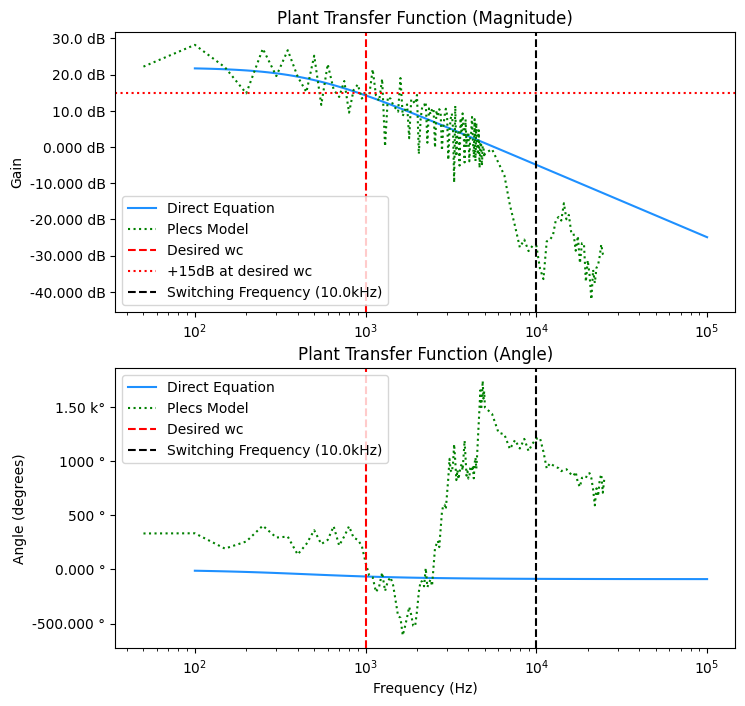

In [108]:
df_plant = pd.read_csv(f"{plecs_data_folder}/plant_bode.csv")
df_plant.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

switching_frequency_hz = 1e4 # Hz
expected_wc = switching_frequency_hz / 10
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")
w = np.logspace(2, 5, 100) # * units.hertz

new_R_Iout_shunt = R_peak_Isense.to(units.ohm).magnitude
new_Rload = R_out_Isense.to(units.ohm).magnitude + Rbat.to(units.ohm).magnitude
new_Cload = Cout.to(units.farad).magnitude
new_mystery_factor = 100 # 14
theoretical_plant_bode = new_Rload / (1 + (2 * np.pi * 1j * w) * new_Rload * new_Cload) / new_Rload * new_R_Iout_shunt * 1.25 * 20 * new_mystery_factor
desired_gain_db = 15
desired_phase_margin_degrees = 40

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Plant Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_plant_bode), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_plant["w"], df_plant["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Desired wc")
ax1.axhline(y = desired_gain_db, linestyle = "dotted", color = "red", label = f"+{desired_gain_db}dB at desired wc")
ax1.axvline(x = switching_frequency_hz, linestyle = "dashed", color = "black", label = f"Switching Frequency ({switching_frequency_hz / 1000}kHz)")
ax1.legend(loc = "lower left")

# initial_phase_margin_theory = -48
# initial_phase_margin_plecs = -60
helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Plant Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_plant_bode, deg = True), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax2.semilogx(df_plant["w"], df_plant["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Desired wc")
ax2.axvline(x = switching_frequency_hz, linestyle = "dashed", color = "black", label = f"Switching Frequency ({switching_frequency_hz / 1000}kHz)")
# ax2.axhline(y = initial_phase_margin_theory, linestyle = "dotted", color = "red", label = f"{90 + initial_phase_margin_theory}° phase margin")
# ax2.axhline(y = initial_phase_margin_plecs, linestyle = "dotted", color = "red", label = f"{90 + initial_phase_margin_plecs}° phase margin")
ax2.legend(loc = "upper left")

Ok, so the PLECS model matches the theory pretty well, at least for the magnitude (after applying the appropriate mystery factor---see the small buck converter parameter notebook). For this model, for some reason, the phase graph is all over the place. I tried varying several different parameters, and none of the versions had a stable phase graph. Instead of deriving any values from the phase graph, I relied on my experience from previous versions of these calculations, where the phase graph matches the magnitude graph. Since my switching frequency is 5 times lower than for the small buck converter, I decided on a target crossover frequency of 1kHz, which is 5 times lower as well.

Experience with similar calculations for the small buck converter suggests that the phase margin at the crossover frequency is probably around 30-40 degrees. I tested two sets of compensator values, one with a phase boost of 40 degrees and another with a phase boost of 60 degrees. The 40 degree boost worked better in terms of having a shorter response time.

Design parameters are a gain cross-over frequency at 1kHz, gain factor of -15dB to make the gain crossover occur at that frequency (obtained from the simulated transfer function above), and phase boost of 40 degrees. I used a Type II compensator consisting of an integrating pole and a lead element like we used in class for the buck-boost converter.

### Finding the compensator values
**Using code copied from Lab 11**

In [109]:
class Compensator:
    def __init__(self, angle_boost_degrees, Kp_decibel_attenuation, Rf1_unitless):
        self.Rf1 = Rf1_unitless * units.ohm
        self.angle_boost = angle_boost_degrees * units.degree
        self.Kp = 1 / from_db(Kp_decibel_attenuation)
        self.find_values()

    def __repr__(self) -> str:
        return f"K: {self.K},\t Gc0: {self.Gc0.to_compact()},\t Rf1: {self.Rf1.to_compact(units.ohm)},\t Rc1: {self.Rc1.to_compact(units.ohm)},\t Cc1: {self.Cc1.to_compact(units.farad)},  \t Cc2: {self.Cc2.to_compact(units.farad)}"

    def find_values(self):
        self.wc = switching_frequency_hz * units.hertz * units.revolutions / 10

        # self.angle_boost = 60 * units.degree
        self.K = np.tan((self.angle_boost / 2 + 45 * units.degree))
        # self.Kp = 1 / from_db(26) # from_db(19) # from_db(13) # from_db(32)
        self.wz = self.wc / self.K
        self.wp = self.wc * self.K
        self.Gc0 = self.Kp * self.wc * np.sqrt((1 + self.K ** (-2)) / (1 + self.K ** 2))
        self.Cc1 = 1 / (self.Gc0 * self.Rf1)
        self.Rc1 = 1 / (self.wz * self.Cc1)
        self.Cc2 = 1 / (self.wp * self.Rc1)

for R in [1.27, 1.3, 1.4, 1.43, 1.47, 1.5, 1.6, 1.8, 2, 2.2, 2.26, 2.7, 3.3, 3.9, 4.02, 4.12, 4.3, 4.7, 4.87, 5.1, 5.6, 6.2, 6.34, 6.8, 7.5, 8.2, 10]: # values to try in kiloohms
    R_to_highlight = 4.12
    if R == R_to_highlight:
        print() # highlight the chosen value
    compensator = Compensator(angle_boost_degrees = desired_phase_margin_degrees, Kp_decibel_attenuation = desired_gain_db, Rf1_unitless = R * 1e3)
    print(compensator)
    if R == R_to_highlight:
        print()

K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 1.27 kΩ,	 Rc1: 225.84 Ω,	 Cc1: 1.51 µF,  	 Cc2: 328.62 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 1.30 kΩ,	 Rc1: 231.18 Ω,	 Cc1: 1.48 µF,  	 Cc2: 321.03 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 1.40 kΩ,	 Rc1: 248.96 Ω,	 Cc1: 1.37 µF,  	 Cc2: 298.10 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 1.43 kΩ,	 Rc1: 254.29 Ω,	 Cc1: 1.34 µF,  	 Cc2: 291.85 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 1.47 kΩ,	 Rc1: 261.41 Ω,	 Cc1: 1.31 µF,  	 Cc2: 283.91 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 1.50 kΩ,	 Rc1: 266.74 Ω,	 Cc1: 1.28 µF,  	 Cc2: 278.23 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 1.60 kΩ,	 Rc1: 284.52 Ω,	 Cc1: 1.20 µF,  	 Cc2: 260.84 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 1.80 kΩ,	 Rc1: 320.09 Ω,	 Cc1: 1.07 µF,  	 Cc2: 231.86 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 2.00 kΩ,	 Rc1: 355.66 Ω,	 Cc1: 959.66 nF,  	 Cc2: 208.67 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 2.20 kΩ,	 Rc1: 391.22 Ω,	 Cc1: 872.42 nF,  	 Cc2: 189.70 nF
K: 2.14,	 Gc0: 82.92 Hz·turn,	 Rf1: 2.26 kΩ,	 Rc1: 401.8

The highlighted row yields nice capacitance values fo 470nF and 100nF, which are easily available. Resistors are chosen at 4.12kΩ and 732Ω, respectively. All of these are standard passive component values.

### Compensator Transfer Function
PLECS Model: [`frequency_experiment_compensator_only.plecs`](https://github.com/ianeyk/wind-turbine/blob/main/large_wind_turbine/frequency_analysis_buck_converter/large_turbine_frequency_experiment_compensator_only.plecs)

![Compensator Schematic](schematics/v3/compensator.png)

I ran the frequency analysis in PLECS to determine the transfer function, as well as writing down the equation based on the components. They match exactly.

Lead element center voltage (ω_c): 1.00 kHz


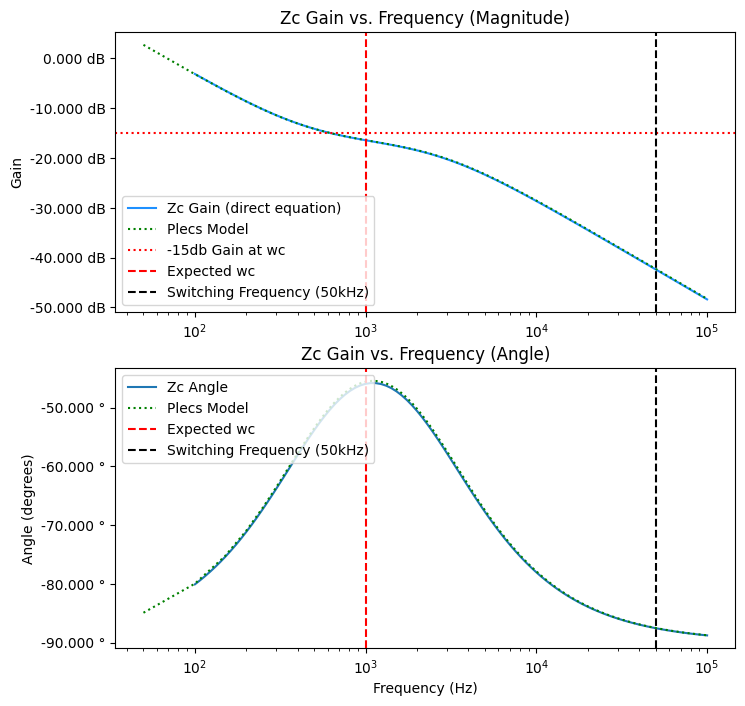

In [110]:
df_compensator = pd.read_csv(f"{plecs_data_folder}/compensator_bode.csv")
df_compensator.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

# chosen values
compensator = Compensator(angle_boost_degrees = desired_phase_margin_degrees, Kp_decibel_attenuation = desired_gain_db, Rf1_unitless = R_to_highlight * 1e3)
Rf1 = compensator.Rf1.to(units.ohm).magnitude
Rc1 = compensator.Rc1.to(units.ohm).magnitude
Cc1 = compensator.Cc1.to(units.farad).magnitude
Cc2 = compensator.Cc2.to(units.farad).magnitude
expected_wc = 1 / (Rc1 * np.sqrt(Cc1 * Cc2)) / 2 / np.pi # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")

w = np.logspace(2, 5, 100) # * units.hertz
def get_Zc(my_w):
    my_Zc = 1 / (1 / (Rc1 + 1 / (2 * np.pi * 1j * my_w * Cc1)) + 1 / (1 / (2 * np.pi * 1j * my_w * Cc2))) / Rf1 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", color = "dodgerblue", label = "Zc Gain (direct equation)")
ax1.semilogx(df_compensator["w"], df_compensator["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = -desired_gain_db, linestyle = "dotted", color = "red", label = f"{-desired_gain_db}db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Zc Gain vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(df_compensator["w"], df_compensator["CH2"] + 180, linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

### Open-Loop Transfer Function
PLECS Model: [`frequency_experiment_10a.plecs`](https://github.com/ianeyk/wind-turbine/blob/main/large_wind_turbine/frequency_analysis_buck_converter/large_turbinefrequency_experiment_10a.plecs)

![Open-Loop Schematic](schematics/v3/frequency_experiment_10a.png)

(-270.0, -60.0)

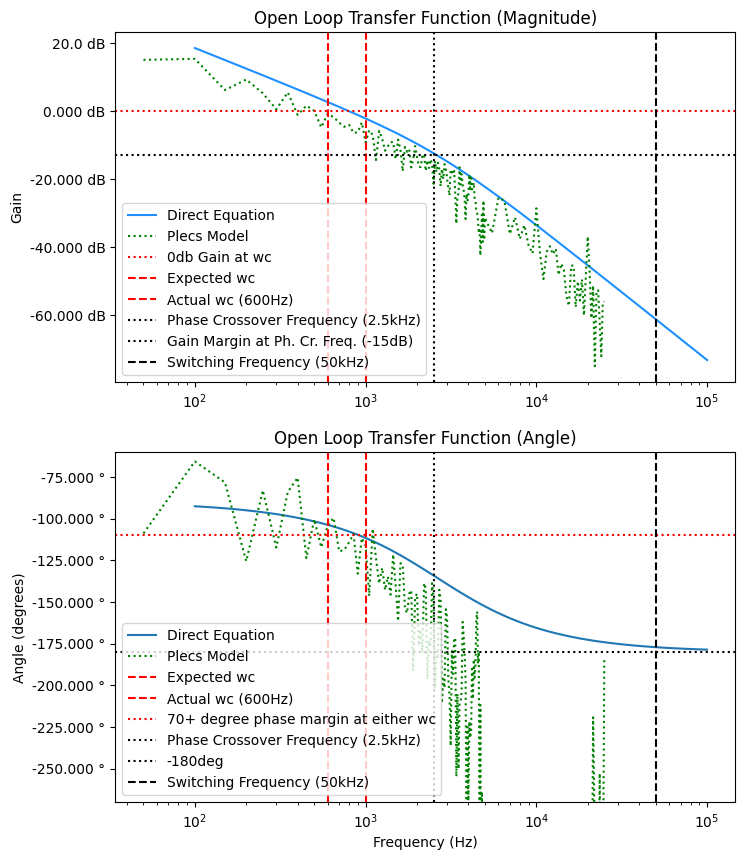

In [111]:
# df_open_loop = pd.read_csv("plecs_data/current_500mA/open_loop_bode_no_quiescent.csv")
df_open_loop = pd.read_csv(f"{plecs_data_folder}/open_loop_bode.csv")
df_open_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_open_loop = theoretical_plant_bode * Zc

phase_crossover_frequency_hz = 2.5e3
actual_gain_crossover_frequency_hz = 600
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 10))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Open Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_open_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_open_loop["w"], df_open_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = 0, linestyle = "dotted", color = "red", label = "0db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = actual_gain_crossover_frequency_hz, linestyle = "dashed", color = "red", label = f"Actual wc ({actual_gain_crossover_frequency_hz}Hz)")
ax1.axvline(x = phase_crossover_frequency_hz, linestyle = "dotted", color = "black", label = f"Phase Crossover Frequency ({phase_crossover_frequency_hz / 1e3}kHz)")
ax1.axhline(y = -13, linestyle = "dotted", color = "black", label = "Gain Margin at Ph. Cr. Freq. (-15dB)")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Open Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_open_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_open_loop["w"], df_open_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = actual_gain_crossover_frequency_hz, linestyle = "dashed", color = "red", label = f"Actual wc ({actual_gain_crossover_frequency_hz}Hz)")
ax2.axhline(y = -110, linestyle = "dotted", color = "red", label = "70+ degree phase margin at either wc")
ax2.axvline(x = phase_crossover_frequency_hz, linestyle = "dotted", color = "black", label = f"Phase Crossover Frequency ({phase_crossover_frequency_hz / 1e3}kHz)")
ax2.axhline(y = -180, linestyle = "dotted", color = "black", label = "-180deg")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "lower left")
ax2.set_ylim(-270, -60)

It looks good! We have an open-loop transfer function that looks good and mostly matches expectations. It has infinite gain at DC, a fat phase margin at the crossover frequency, and strong attenuation at high frequencies. The phase plot falls off a lot faster than expected after the gain crossover frequency, but this is of no real importance to us because the gain margin at the phase crossover frequency is on the order of -13dB.

The principal difference is that the gain crossover frequency (wc) is somewhere between 600Hz and 800Hz (depending on your accounting method---whether you trust the PLECS model or the mathematical equation), instead of the 1kHz requested. This also is not a worrying factor, because at lower gain crossover frequencies, the phase margin is larger. At 1kHz, the phase margin is 70 degrees, and at 600kHz, it is closer to 80 degrees. Compare this to the industry standard we adopted in Power Electronics, which is 60 degrees or greater.

### Closed-Loop Transfer Function
PLECS Model: Same as open-loop [`frequency_experiment_10a.plecs`](https://github.com/ianeyk/wind-turbine/blob/main/large_wind_turbine/frequency_analysis_buck_converter/large_turbine_frequency_experiment_10a.plecs) except flip the switch from the open-loop side to the closed-loop side on the Analog Discovery model.

![Closed-Loop Schematic](schematics/v3/frequency_experiment_10b.png)

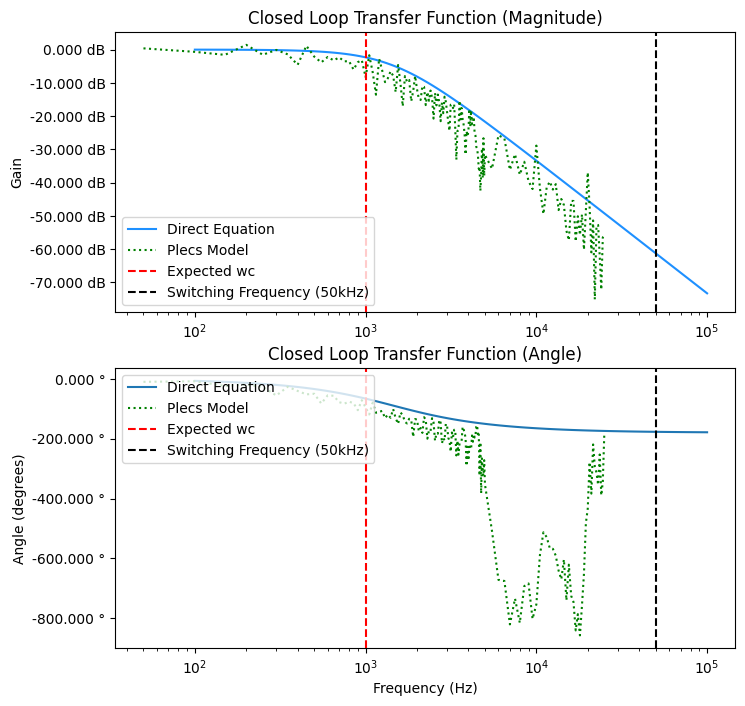

In [112]:
df_closed_loop = pd.read_csv(f"{plecs_data_folder}/closed_loop_bode.csv")
# df_closed_loop = pd.read_csv("plecs_data/current_500mA/closed_loop_bode.csv")
df_closed_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_closed_loop = theoretical_open_loop / (1 + theoretical_open_loop)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Closed Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_closed_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_closed_loop["w"], df_closed_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Closed Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_closed_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_closed_loop["w"], df_closed_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

Again, the theory and the PLECS model match pretty well, ignoring the part of the phase graph that is above the switching frequency. The system has a gain of 1 at DC and strong attenuation well before the switching frequency, exactly as we want.

### Time Response
Lastly, I implemented a square wave signal to the voltage adder to simulate a change in the desired current. The [PLECS model](https://github.com/ianeyk/wind-turbine/blob/main/small_wind_turbine/3phase_generator_buck_converter.plecs) is the same model shown at the start of this notebook.

![Entire PLECS Schematic](schematics/v3/full_schematic.png)


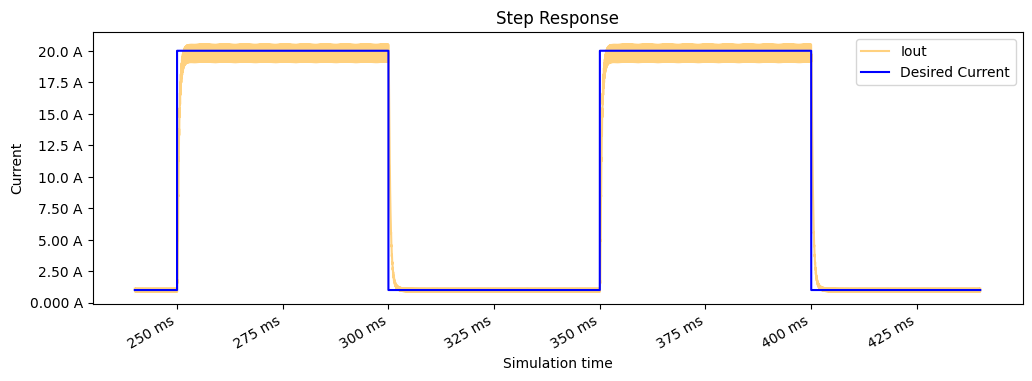

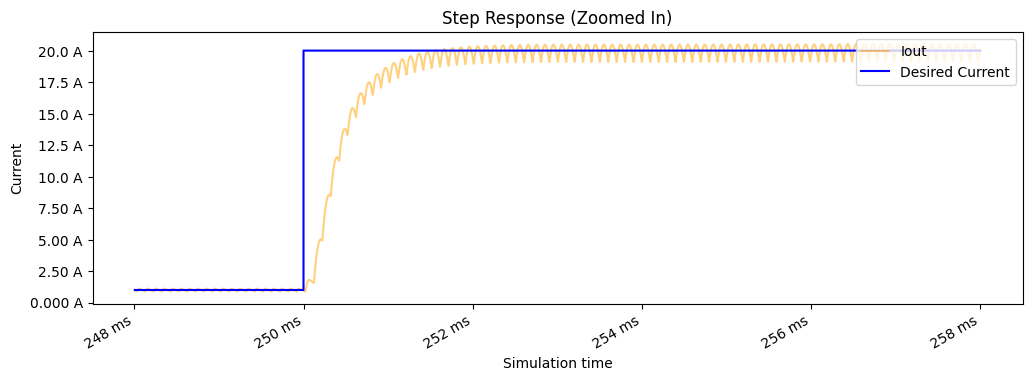

In [113]:
# df_old = pd.read_csv(f"{plecs_data_folder}/square_wave_response.csv")
# df_old = pd.read_csv("plecs_data/inductor_330uH/square_wave_response_1_27kOhm.csv")
df = pd.read_csv(f"{plecs_data_folder}/square_wave_response.csv")
# df_old.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
# df_old["Iexpected"] = .5 * (1 - df_old["Pulse Generator"] / 2.5) - 0.25
# df_old_envelope = df_old.loc[(df_old["Time / s"] > 10e-3) & (df_old["Time / s"] < 40e-3)]
df["Iexpected"] = 20 * (1 - df["Pulse Generator"] / 2.5)
df_envelope = df.loc[(df["Time / s"] > 0.24) & (df["Time / s"] < 0.44)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
# ax1.plot(df_old_envelope["Time / s"], df_old_envelope["Iout"], color = "purple", label = "Iout Old")
ax1.plot(df_envelope["Time / s"], df_envelope["Iout"], color = "orange", alpha = 0.5, label = "Iout")
ax1.plot(df_envelope["Time / s"], df_envelope["Iexpected"], color = "blue", label = "Desired Current")
helper.axes_labels("Simulation time", "s", "Current", "A", title = "Step Response", ax = ax1)
ax1.legend(loc = "upper right")

# df_old_zoom = df_old.loc[(df_old["Time / s"] > 24.8e-3) & (df_old["Time / s"] < 25.8e-3)]
df_zoom = df.loc[(df["Time / s"] > 248e-3) & (df["Time / s"] < 258e-3)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
helper.axes_labels("Simulation time", "s", "Current", "A", title = "Step Response (Zoomed In)", ax = ax1)
# ax1.plot(df_old_zoom["Time / s"], df_old_zoom["Iout"], color = "purple", label = "Iout Old")
ax1.plot(df_zoom["Time / s"], df_zoom["Iout"], color = "orange", alpha = 0.5, label = "Iout")
ax1.plot(df_zoom["Time / s"], df_zoom["Iexpected"], color = "blue", label = "Desired Current")
ax1.legend(loc = "upper right")

Crucially, the control loop is overdamped, so the current does not overshoot the target current. This is important so that we don't temporarily dump more current into the battery than it can handle---we are always on the lower side of the target current on the rising edge. The output current settles on the target current in well under 5 milliseconds. This is much slower than the small buck converter, which had a faster switching frequency, but it is altogether plenty fast for the application, since we intend to change the target current only on the time frame of several minutes.

This test case also proves that the current can swing essentially the entire range of the buck converter, from 1A up to 20A and back down with no overshoot, quickly, and with no other issues.